<a href="https://colab.research.google.com/github/atr3002/Binary-Classification-Framework/blob/main/MLTask1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 1: Exploratory Data Analysis

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
from scipy.stats import pointbiserialr
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Visual style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

Data Loading and Initial Exploration

In [2]:
# Download dataset
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

# Exact filename
print(os.listdir(path))

# Load the CSV
df = pd.read_csv(os.path.join(path, "WA_Fn-UseC_-Telco-Customer-Churn.csv"))

Using Colab cache for faster access to the 'telco-customer-churn' dataset.
['WA_Fn-UseC_-Telco-Customer-Churn.csv']


In [3]:
# Dataset shape
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}\n")

# First 5 rows
print(f"{df.head()}\n")

# Dataset information
print(df.info())

Rows: 7043, Columns: 21

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMo

In [4]:
# If customerID is unique there will be 7043 values
print(f"'customerID' unique values count: {df['customerID'].nunique()}")

'customerID' unique values count: 7043


Data Quality Assessment

In [5]:
# Missing values analysis
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [6]:
# Duplicate records
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 0


In [7]:
# Data type verification
print(df.dtypes)

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [8]:
# Checking for unique values of "TotalCharges"
print(f"'TotalCharges' unique values count: {df['TotalCharges'].nunique()}")
print("Sample values of 'TotalCharges':", df['TotalCharges'].unique()[:10])

'TotalCharges' unique values count: 6531
Sample values of 'TotalCharges': ['29.85' '1889.5' '108.15' '1840.75' '151.65' '820.5' '1949.4' '301.9'
 '3046.05' '3487.95']


Data Cleaning

In [9]:
# Convert SeniorCitizen to categorical
print("\nConverting SeniorCitizen from numeric to categorical...")
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})
print(f"SeniorCitizen unique values after conversion: {df['SeniorCitizen'].unique()}")


Converting SeniorCitizen from numeric to categorical...
SeniorCitizen unique values after conversion: ['No' 'Yes']


In [10]:
# Convert TotalCharges to numeric (create NaN for non-numeric)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [11]:
# After converting TotalCharges to numeric
print(f"Missing values in TotalCharges: {df['TotalCharges'].isnull().sum()}")

Missing values in TotalCharges: 11


In [12]:
missing_records = df[df['TotalCharges'].isnull()]

# All 11 records with missing "TotalCharges"

# Show only the columns needed
simple_view = missing_records[['customerID', 'TotalCharges', 'Churn']]

print(simple_view)

      customerID  TotalCharges Churn
488   4472-LVYGI           NaN    No
753   3115-CZMZD           NaN    No
936   5709-LVOEQ           NaN    No
1082  4367-NUYAO           NaN    No
1340  1371-DWPAZ           NaN    No
3331  7644-OMVMY           NaN    No
3826  3213-VVOLG           NaN    No
4380  2520-SGTTA           NaN    No
5218  2923-ARZLG           NaN    No
6670  4075-WKNIU           NaN    No
6754  2775-SEFEE           NaN    No


In [13]:
# Calculate TotalCharges statistics by churn group
print("\nStatistics by Churn Group:")
stats_by_churn = df.groupby('Churn')['TotalCharges'].agg(['mean', 'median', 'count'])
print(stats_by_churn)
print()

# Calculate overall mean and median for "TotalCharges"
mean_value = df['TotalCharges'].mean()
median_value = df['TotalCharges'].median()
print("TotalCharges Statistics:")
print(f"Mean:  {mean_value:,.2f}  ,  Median: {median_value:,.2f}")


Statistics by Churn Group:
              mean   median  count
Churn                             
No     2555.344141  1683.60   5163
Yes    1531.796094   703.55   1869

TotalCharges Statistics:
Mean:  2,283.30  ,  Median: 1,397.47


In [14]:
# Calculate TotalCharges median for non-churned customers
non_churned_median = df[df['Churn'] == 'No']['TotalCharges'].median()

df['TotalCharges'] = df.apply(lambda row: non_churned_median if pd.isna(row['TotalCharges']) else row['TotalCharges'],axis=1)

imputed_records = df[df['TotalCharges'] == non_churned_median]

print(imputed_records[['customerID', 'TotalCharges', 'Churn']])

print(f"\nMissing values after imputation: {df['TotalCharges'].isnull().sum()}")

      customerID  TotalCharges Churn
488   4472-LVYGI        1683.6    No
753   3115-CZMZD        1683.6    No
936   5709-LVOEQ        1683.6    No
1082  4367-NUYAO        1683.6    No
1340  1371-DWPAZ        1683.6    No
2062  7996-MHXLW        1683.6    No
3331  7644-OMVMY        1683.6    No
3826  3213-VVOLG        1683.6    No
4380  2520-SGTTA        1683.6    No
5218  2923-ARZLG        1683.6    No
6670  4075-WKNIU        1683.6    No
6754  2775-SEFEE        1683.6    No

Missing values after imputation: 0


In [15]:
# Create a copy for analysis
df_clean = df.copy()

Target Variable Analysis (Churn)

In [16]:
# Churn distribution
churn_counts = df_clean['Churn'].value_counts()
churn_percentage = df_clean['Churn'].value_counts(normalize=True) * 100
print(pd.DataFrame({'Count': churn_counts,'Percentage': churn_percentage}))

       Count  Percentage
Churn                   
No      5174   73.463013
Yes     1869   26.536987


Numerical Features Analysis

In [17]:
# Identify numerical columns
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
print(f"\n Numerical Columns: {numerical_cols}")


 Numerical Columns: ['tenure', 'MonthlyCharges', 'TotalCharges']



 Statistical Summary:
            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2282.363808
std      24.559481       30.090047   2265.124074
min       0.000000       18.250000     18.800000
25%       9.000000       35.500000    402.225000
50%      29.000000       70.350000   1400.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000



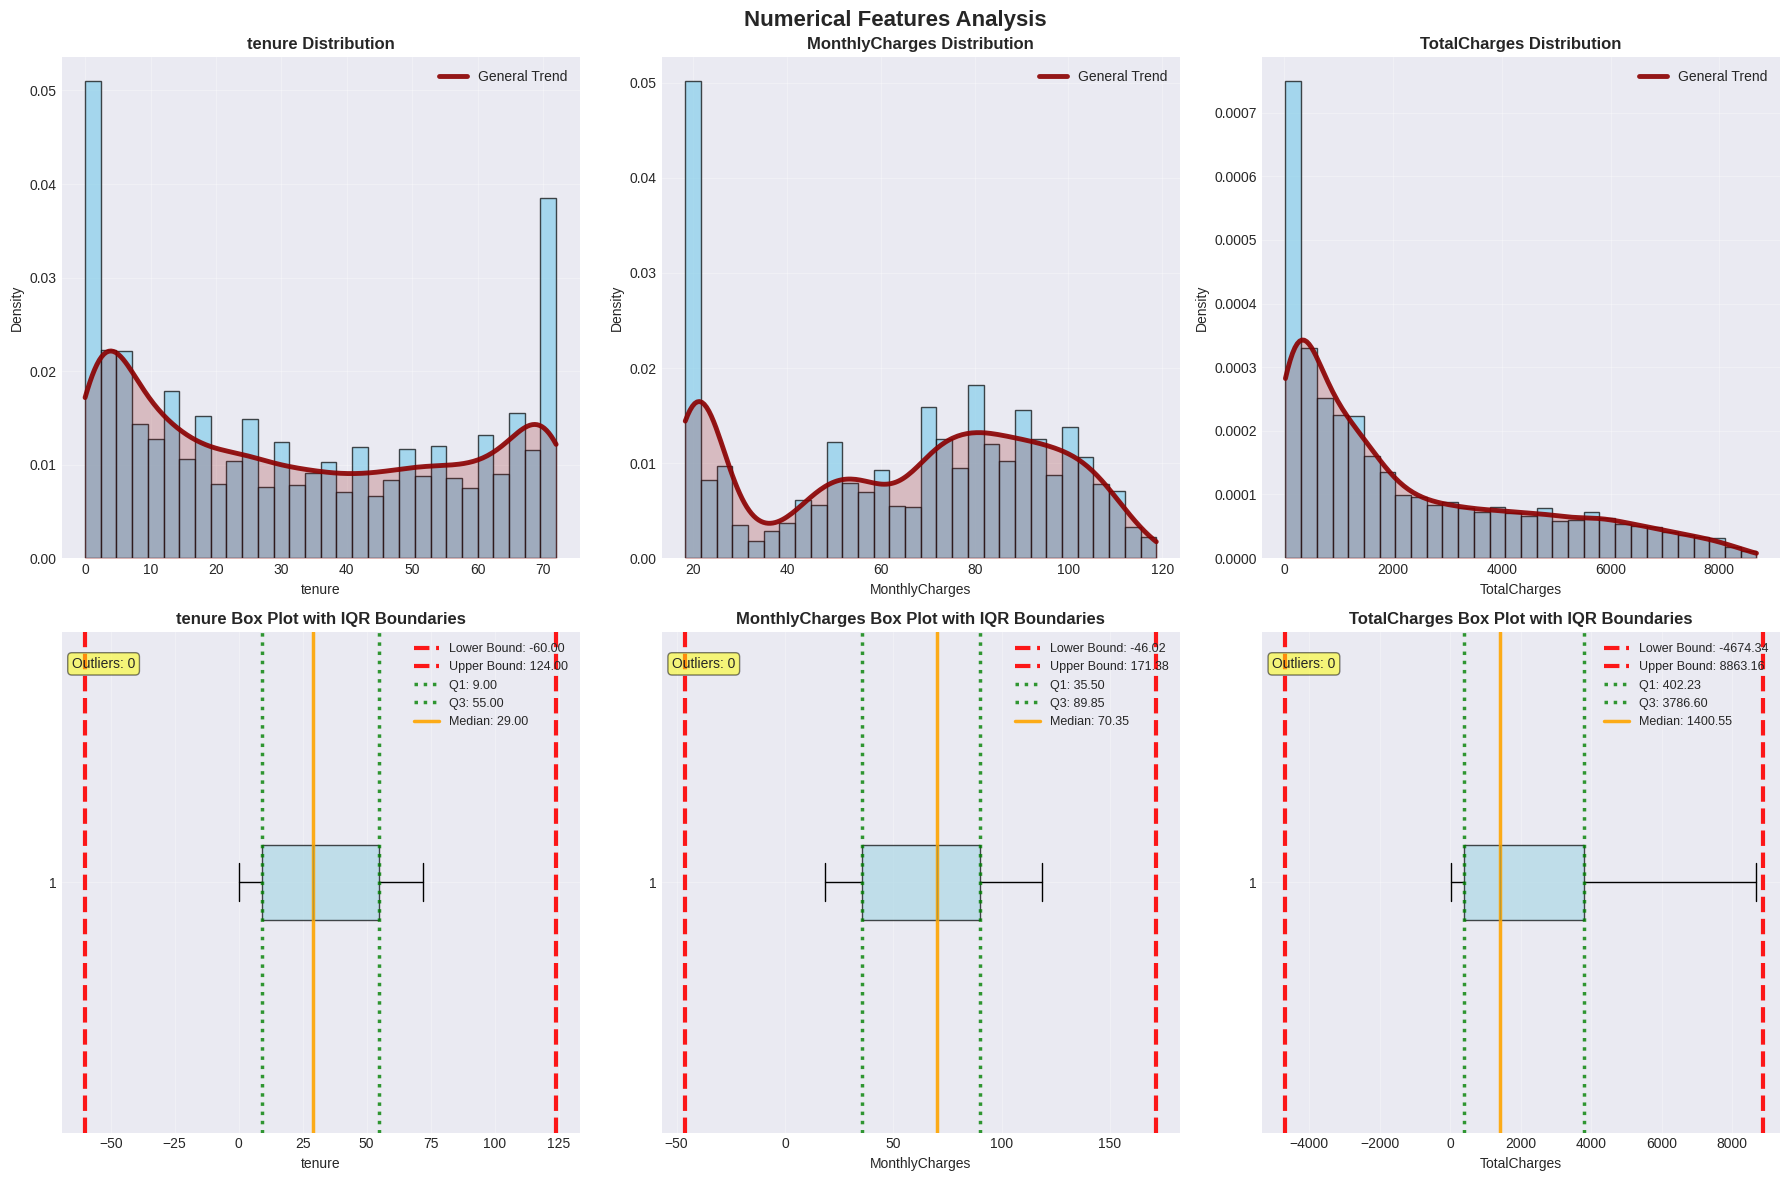


 IQR-Based Outlier Analysis:

tenure:
  Q1: 9.0000, Q3: 55.0000, IQR: 46.0000
  Lower Bound: -60.0000, Upper Bound: 124.0000
  Outliers: 0 (0.00%)

MonthlyCharges:
  Q1: 35.5000, Q3: 89.8500, IQR: 54.3500
  Lower Bound: -46.0250, Upper Bound: 171.3750
  Outliers: 0 (0.00%)

TotalCharges:
  Q1: 402.2250, Q3: 3786.6000, IQR: 3384.3750
  Lower Bound: -4674.3375, Upper Bound: 8863.1625
  Outliers: 0 (0.00%)


In [18]:
print("\n Statistical Summary:")
print(f"{df_clean[numerical_cols].describe()}\n")

# Visualization of numerical features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Numerical Features Analysis', fontsize=16, fontweight='bold')

for idx, col in enumerate(numerical_cols):
    data = df_clean[col].dropna()

    # Histogram with smooth KDE trend line
    n, bins, patches = axes[0, idx].hist(data, bins=30, edgecolor='black',
                                        alpha=0.7, color='skyblue', density=True)
    axes[0, idx].set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
    axes[0, idx].set_xlabel(col)
    axes[0, idx].set_ylabel('Density')

    # Add smooth KDE trend line (General curve)
    kde = gaussian_kde(data)
    x_kde = np.linspace(data.min(), data.max(), 200)  # 200 points for smooth curve
    y_kde = kde(x_kde)

    # Plot the smooth curve with increased visibility
    axes[0, idx].plot(x_kde, y_kde, color='darkred', linewidth=3.5,
                     label='General Trend', alpha=0.9)

    # Fill under the curve for better visualization
    axes[0, idx].fill_between(x_kde, y_kde, alpha=0.2, color='darkred')

    axes[0, idx].legend(loc='upper right')
    axes[0, idx].grid(True, alpha=0.3)

    # Box plot with IQR boundary lines
    bp = axes[1, idx].boxplot(data, vert=False, patch_artist=True,
                              boxprops=dict(facecolor='lightblue', alpha=0.7))

    # Calculate IQR and boundaries
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Add IQR boundary lines with different colors and increased width
    axes[1, idx].axvline(x=lower_bound, color='red', linestyle='--',
                         linewidth=3, alpha=0.9, label=f'Lower Bound: {lower_bound:.2f}')
    axes[1, idx].axvline(x=upper_bound, color='red', linestyle='--',
                         linewidth=3, alpha=0.9, label=f'Upper Bound: {upper_bound:.2f}')

    # Add quartile lines
    axes[1, idx].axvline(x=Q1, color='green', linestyle=':',
                         linewidth=2.5, alpha=0.8, label=f'Q1: {Q1:.2f}')
    axes[1, idx].axvline(x=Q3, color='green', linestyle=':',
                         linewidth=2.5, alpha=0.8, label=f'Q3: {Q3:.2f}')

    # Mark median
    median = np.median(data)
    axes[1, idx].axvline(x=median, color='orange', linestyle='-',
                         linewidth=2.5, alpha=0.9, label=f'Median: {median:.2f}')

    axes[1, idx].set_title(f'{col} Box Plot with IQR Boundaries', fontsize=12, fontweight='bold')
    axes[1, idx].set_xlabel(col)
    axes[1, idx].legend(loc='upper right', fontsize=9)
    axes[1, idx].grid(True, alpha=0.3)

    # Add text annotation for outlier count
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    outlier_count = len(outliers)
    axes[1, idx].text(0.02, 0.95, f'Outliers: {outlier_count}',
                     transform=axes[1, idx].transAxes, fontsize=10,
                     verticalalignment='top', bbox=dict(boxstyle='round',
                                                      facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.show()

# Print IQR summary for all numerical columns
print("\n IQR-Based Outlier Analysis:")
for col in numerical_cols:
    data = df_clean[col].dropna()
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]

    print(f"\n{col}:")
    print(f"  Q1: {Q1:.4f}, Q3: {Q3:.4f}, IQR: {IQR:.4f}")
    print(f"  Lower Bound: {lower_bound:.4f}, Upper Bound: {upper_bound:.4f}")
    print(f"  Outliers: {len(outliers)} ({len(outliers)/len(data)*100:.2f}%)")
    if len(outliers) > 0:
        print(f"  Outlier Range: [{outliers.min():.4f}, {outliers.max():.4f}]")


 Correlation Analysis:
                  tenure  MonthlyCharges  TotalCharges
tenure          1.000000        0.247900      0.825257
MonthlyCharges  0.247900        1.000000      0.650753
TotalCharges    0.825257        0.650753      1.000000



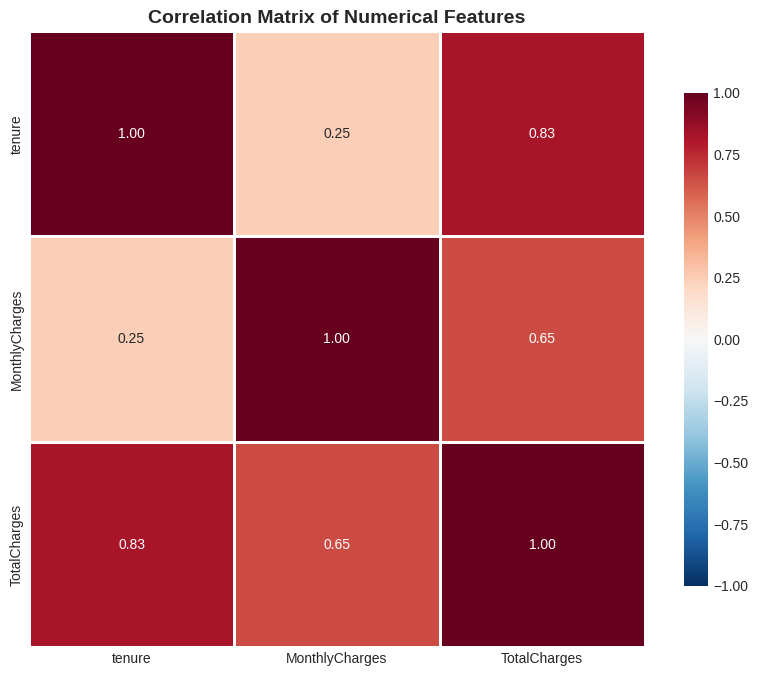

In [19]:
print("\n Correlation Analysis:")
correlation_matrix = df_clean[numerical_cols].corr()
print(f"{correlation_matrix}\n")

# Correlation heatmap
plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix,
            annot=True,
            cmap='RdBu_r',
            fmt='.2f',
            square=True,
            cbar_kws={'shrink': 0.8},
            linewidths=1,
            center=0,  # Center at 0 for better red/blue distinction
            vmin=-1,   # Minimum correlation
            vmax=1)    # Maximum correlation

plt.title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold')
plt.show()

Categorical Features Analysis

In [20]:
# Identify categorical columns (excluding customerID and Churn)
categorical_cols = [col for col in df_clean.columns
                    if df_clean[col].dtype == 'object' and col not in ['customerID', 'Churn']]

print(f"\n Categorical Columns ({len(categorical_cols)}):")
print("-" * 60)

for col in categorical_cols:
    value_counts = df_clean[col].value_counts()
    total_count = len(df_clean)

    print(f"\n{col.upper()} ({df_clean[col].nunique()} unique values):")
    print("-" * 40)

    # Print each value with count and percentage
    for idx, (value, count) in enumerate(value_counts.items()):
        percentage = (count / total_count) * 100
        print(f"  {idx+1:2d}. {value:20s}: {count:6d} ({percentage:6.2f}%)")

    print(f"  Total: {total_count:6d} rows")


 Categorical Columns (16):
------------------------------------------------------------

GENDER (2 unique values):
----------------------------------------
   1. Male                :   3555 ( 50.48%)
   2. Female              :   3488 ( 49.52%)
  Total:   7043 rows

SENIORCITIZEN (2 unique values):
----------------------------------------
   1. No                  :   5901 ( 83.79%)
   2. Yes                 :   1142 ( 16.21%)
  Total:   7043 rows

PARTNER (2 unique values):
----------------------------------------
   1. No                  :   3641 ( 51.70%)
   2. Yes                 :   3402 ( 48.30%)
  Total:   7043 rows

DEPENDENTS (2 unique values):
----------------------------------------
   1. No                  :   4933 ( 70.04%)
   2. Yes                 :   2110 ( 29.96%)
  Total:   7043 rows

PHONESERVICE (2 unique values):
----------------------------------------
   1. Yes                 :   6361 ( 90.32%)
   2. No                  :    682 (  9.68%)
  Total:   7043 row

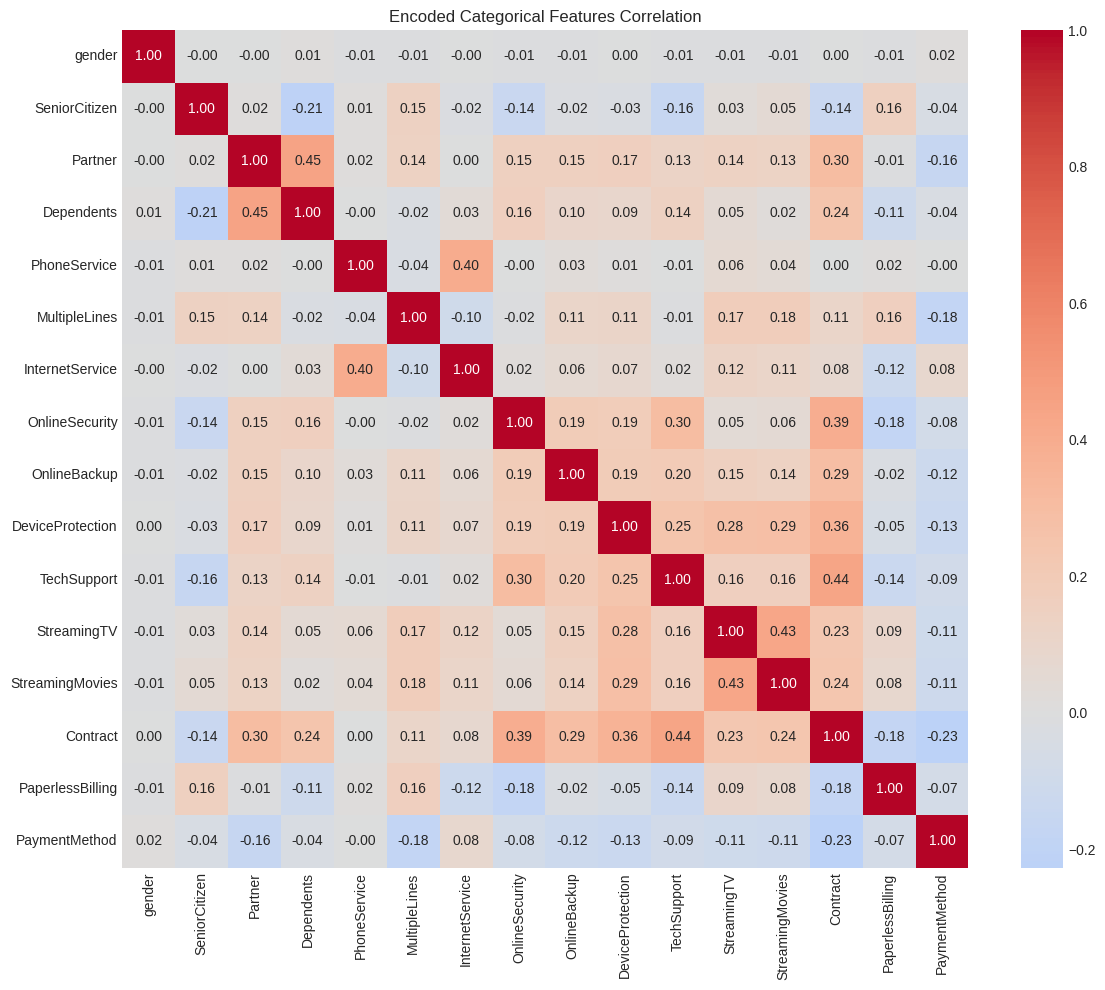

In [21]:
# Encode categorical variables and check correlation
# Create encoded copy
df_encoded = df[categorical_cols].copy()
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col].astype(str))

# Calculate correlation matrix
encoded_corr = df_encoded.corr(method='spearman')  # Spearman for ordinal-like

plt.figure(figsize=(12, 10))
sns.heatmap(encoded_corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title("Encoded Categorical Features Correlation")
plt.tight_layout()
plt.show()

Relationship with Churn


 Churn Rate by Numerical Features:
Overall Churn Rate: 26.54%


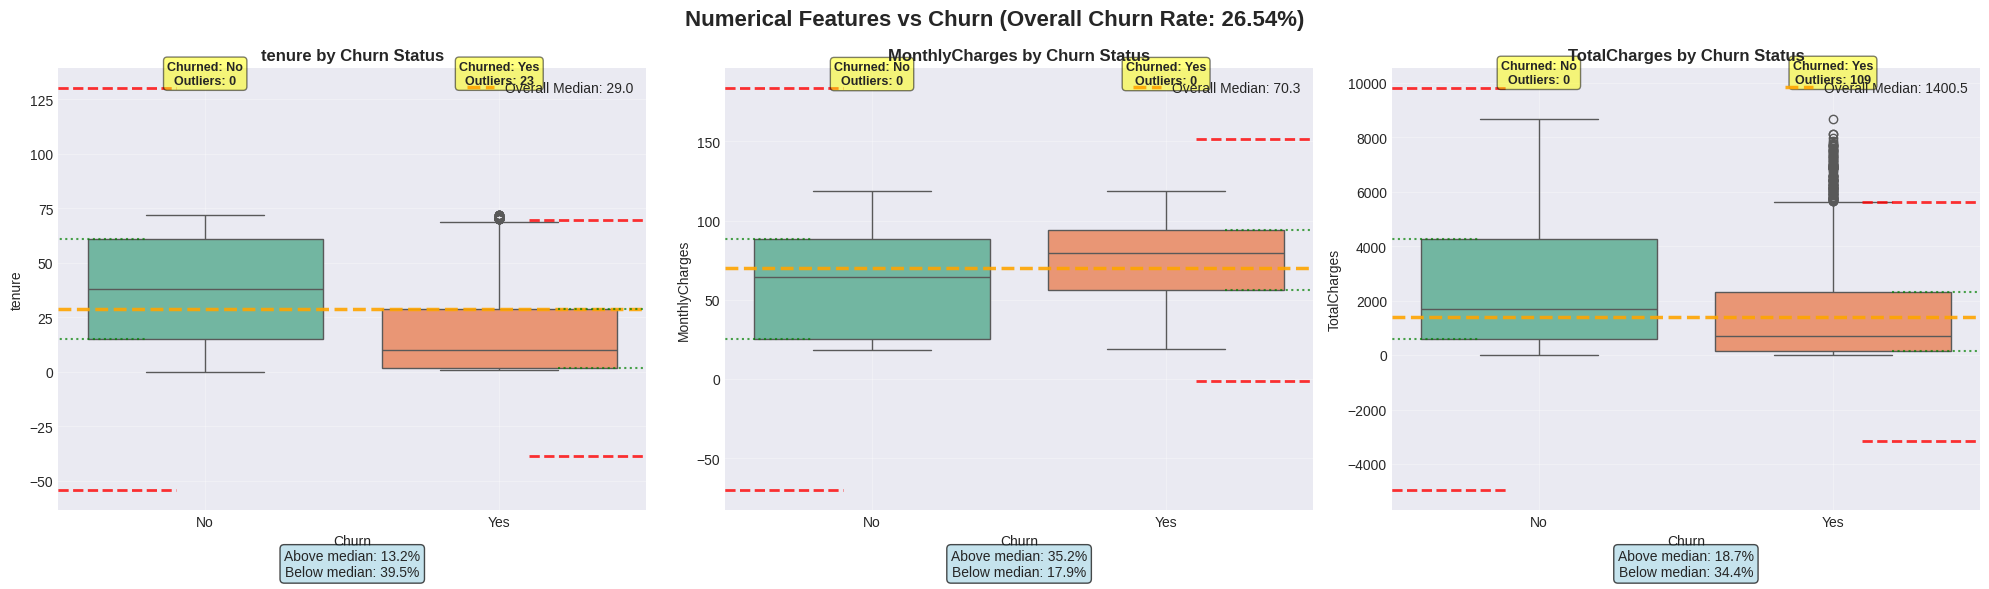


Detailed Statistics by Churn Status:

TENURE:
----------------------------------------
  Overall Median: 29.00

  Churn = No (n=5174):
    Mean: 37.57, Median: 38.00 (Diff from overall: +9.00)
    Q1: 15.00, Q3: 61.00, IQR: 46.00
    Lower bound: -54.00, Upper bound: 130.00
    Outliers: 0 (0.0%)

  Churn = Yes (n=1869):
    Mean: 17.98, Median: 10.00 (Diff from overall: -19.00)
    Q1: 2.00, Q3: 29.00, IQR: 27.00
    Lower bound: -38.50, Upper bound: 69.50
    Outliers: 23 (1.2%)

  Correlation with churn: -0.352 (p-value: 0.0000)

MONTHLYCHARGES:
----------------------------------------
  Overall Median: 70.35

  Churn = No (n=5174):
    Mean: 61.27, Median: 64.43 (Diff from overall: -5.92)
    Q1: 25.10, Q3: 88.40, IQR: 63.30
    Lower bound: -69.85, Upper bound: 183.35
    Outliers: 0 (0.0%)

  Churn = Yes (n=1869):
    Mean: 74.44, Median: 79.65 (Diff from overall: +9.30)
    Q1: 56.15, Q3: 94.20, IQR: 38.05
    Lower bound: -0.93, Upper bound: 151.28
    Outliers: 0 (0.0%)

  Co

In [22]:
print("\n Churn Rate by Numerical Features:")

# Calculate overall churn rate
churn_rate = (df_clean['Churn'] == 'Yes').mean() * 100
print(f"Overall Churn Rate: {churn_rate:.2f}%")

# Create subplots for numerical features vs churn
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle(f'Numerical Features vs Churn (Overall Churn Rate: {churn_rate:.2f}%)',
             fontsize=16, fontweight='bold')

for idx, col in enumerate(numerical_cols):
    # Box plot
    sns.boxplot(x='Churn', y=col, data=df_clean, ax=axes[idx], palette='Set2')

    # Calculate overall median
    overall_median = df_clean[col].median()

    # Add overall median line across entire plot
    axes[idx].axhline(y=overall_median, color='orange', linestyle='--',
                     linewidth=2.5, alpha=0.9, label=f'Overall Median: {overall_median:.1f}')

    # Calculate IQR and boundaries for each churn group
    for i, churn_value in enumerate(['No', 'Yes']):
        data = df_clean[df_clean['Churn'] == churn_value][col]

        # Calculate IQR and boundaries
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Calculate x position for this box (centered on box)
        x_position = i  # 0 for 'No', 1 for 'Yes'

        # Add IQR boundary lines
        axes[idx].axhline(y=lower_bound, xmin=x_position-0.2, xmax=x_position+0.2,
                         color='red', linestyle='--', linewidth=2, alpha=0.8)
        axes[idx].axhline(y=upper_bound, xmin=x_position-0.2, xmax=x_position+0.2,
                         color='red', linestyle='--', linewidth=2, alpha=0.8)

        # Add quartile lines
        axes[idx].axhline(y=Q1, xmin=x_position-0.15, xmax=x_position+0.15,
                         color='green', linestyle=':', linewidth=1.5, alpha=0.7)
        axes[idx].axhline(y=Q3, xmin=x_position-0.15, xmax=x_position+0.15,
                         color='green', linestyle=':', linewidth=1.5, alpha=0.7)

        # Calculate churn group statistics
        group_churn_rate = (len(df_clean[df_clean['Churn'] == 'Yes']) / len(df_clean)) * 100
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        outlier_count = len(outliers)

        # Add text annotation
        text = f"Churned: {churn_value}\nOutliers: {outlier_count}"
        axes[idx].text(x_position, axes[idx].get_ylim()[1] * 0.95, text,
                      ha='center', fontsize=9, fontweight='bold',
                      bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

    # Calculate and display churn rate for high/low values
    median_val = df_clean[col].median()
    high_group = df_clean[df_clean[col] > median_val]
    low_group = df_clean[df_clean[col] <= median_val]

    high_churn_rate = (high_group['Churn'] == 'Yes').mean() * 100
    low_churn_rate = (low_group['Churn'] == 'Yes').mean() * 100

    # Add comparison text
    comp_text = f"Above median: {high_churn_rate:.1f}%\nBelow median: {low_churn_rate:.1f}%"
    axes[idx].text(0.5, -0.15, comp_text, transform=axes[idx].transAxes,
                  ha='center', fontsize=10,
                  bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

    axes[idx].set_title(f'{col} by Churn Status', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Churn')
    axes[idx].set_ylabel(col)
    axes[idx].legend(loc='upper right')  # Added legend to show overall median line
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "="*60)
print("Detailed Statistics by Churn Status:")
print("="*60)

for col in numerical_cols:
    print(f"\n{col.upper()}:")
    print("-" * 40)

    # Add overall median to the printout
    overall_median = df_clean[col].median()
    print(f"  Overall Median: {overall_median:.2f}")

    for churn_value in ['No', 'Yes']:
        data = df_clean[df_clean['Churn'] == churn_value][col]
        count = len(data)
        mean_val = data.mean()
        median_val = data.median()
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data < lower_bound) | (data > upper_bound)]

        print(f"\n  Churn = {churn_value} (n={count}):")
        print(f"    Mean: {mean_val:.2f}, Median: {median_val:.2f} (Diff from overall: {median_val - overall_median:+.2f})")
        print(f"    Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
        print(f"    Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
        print(f"    Outliers: {len(outliers)} ({len(outliers)/count*100:.1f}%)")

    # Calculate correlation with churn (point-biserial)
    churn_numeric = df_clean['Churn'].map({'No': 0, 'Yes': 1})
    corr, p_value = pointbiserialr(df_clean[col], churn_numeric)
    print(f"\n  Correlation with churn: {corr:.3f} (p-value: {p_value:.4f})")


 Pairplot of Numerical Features


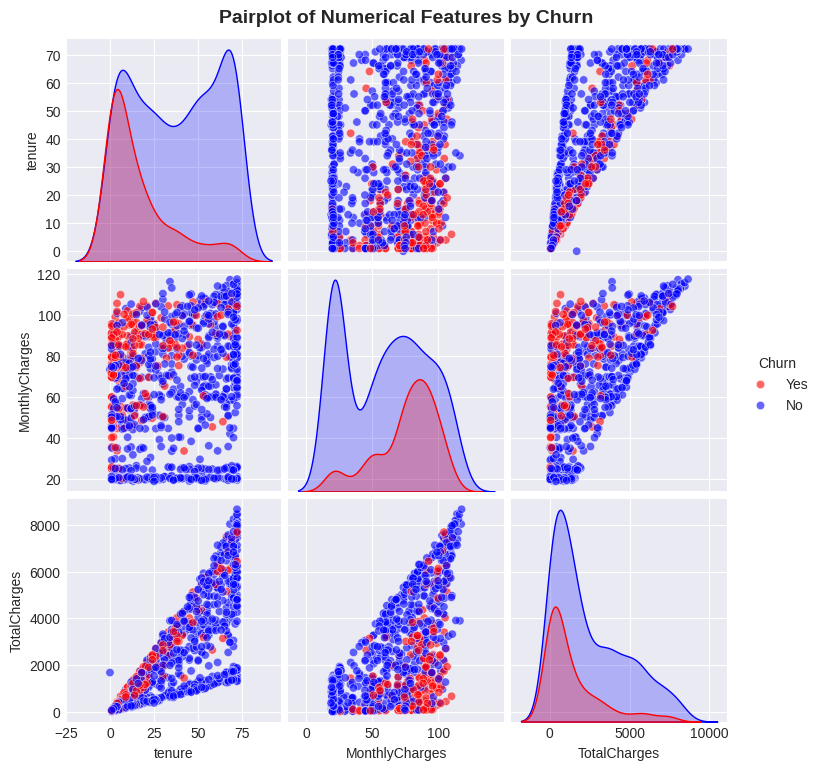

In [23]:
print("\n Pairplot of Numerical Features")
# Take a sample for better visualization
sample_df = df_clean.sample(1000, random_state=42)
g = sns.pairplot(sample_df, vars=numerical_cols, hue='Churn',
                 palette={'No': 'blue', 'Yes': 'red'},
                 diag_kind='kde', plot_kws={'alpha': 0.6})
g.fig.suptitle('Pairplot of Numerical Features by Churn', fontsize=14, fontweight='bold', y=1.02)
plt.show()

In [24]:
print("\n Churn Rate by Categorical Features:")
print("\nCOMPREHENSIVE CROSS-TABULATIONS")

# Get categorical variables
cat_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
            'PhoneService', 'MultipleLines', 'InternetService',
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies',
            'Contract', 'PaperlessBilling', 'PaymentMethod']

for var in cat_vars:
    print(f"\n{var.upper()} ANALYSIS:")
    print('-' * 40)

    # Counts
    counts = pd.crosstab(df_clean[var], df_clean['Churn'])
    print("Counts:")
    print(counts)

    # Row percentages (sum across rows = 100%) - churn rate per category
    row_percentages = pd.crosstab(df_clean[var], df_clean['Churn'], normalize='index') * 100
    print("\nRow Percentages (Churn Rate per Category):")
    print(row_percentages.round(2))

    # Add churn rate column
    churn_rate = row_percentages['Yes'].round(2)
    print(f"\nChurn Rate for each {var} category:")
    for category, rate in churn_rate.items():
        print(f"  {category}: {rate}%")

    # Column percentages (sum across columns = 100%) - This shows distribution within churn groups
    col_percentages = pd.crosstab(df_clean[var], df_clean['Churn'], normalize='columns') * 100
    print("\nColumn Percentages (Distribution within Churn Groups):")
    print(col_percentages.round(2))

    print("\n")


 Churn Rate by Categorical Features:

COMPREHENSIVE CROSS-TABULATIONS

GENDER ANALYSIS:
----------------------------------------
Counts:
Churn     No  Yes
gender           
Female  2549  939
Male    2625  930

Row Percentages (Churn Rate per Category):
Churn      No    Yes
gender              
Female  73.08  26.92
Male    73.84  26.16

Churn Rate for each gender category:
  Female: 26.92%
  Male: 26.16%

Column Percentages (Distribution within Churn Groups):
Churn      No    Yes
gender              
Female  49.27  50.24
Male    50.73  49.76



SENIORCITIZEN ANALYSIS:
----------------------------------------
Counts:
Churn            No   Yes
SeniorCitizen            
No             4508  1393
Yes             666   476

Row Percentages (Churn Rate per Category):
Churn             No    Yes
SeniorCitizen              
No             76.39  23.61
Yes            58.32  41.68

Churn Rate for each SeniorCitizen category:
  No: 23.61%
  Yes: 41.68%

Column Percentages (Distribution within Chu